# task6(Вариант13) - Цзян Чжэнхуа

# нейронной сети метод nnetar(На языке R)

На основании предыдущих результатов была определена наиболее адекватная модель ARMA: SARMA(1,0,0)(0,0,1).

Поэтому при определении параметров было выбрано p = 1 и P = 1, я попробовал тот же случай с большим P, но прогноз был лучше при P = 1.

Вот часть кода на языке R.(Полные результаты выполнения находятся в файле task6.html)

In [2]:
# setwd("C:\\Users\\lenovo\\Desktop\\时间序列分析\\tsa6")
# dat <- read.csv("TrainingData.csv")
# dat <- dat[complete.cases(dat), ]

# x <- ts(dat$Значение,start = c(2017,1),frequency = 12)
# plot(x)

# train_length <- length(x) - 12

# Creating the training set
# train <- window(x, end = c((train_length) %/% frequency(x) + start(x)[1], (train_length) %% frequency(x)))

# Creating Test Sets
# test <- window(x, start = c(train_length %/% frequency(x) + start(x)[1], (train_length %% frequency(x)) + 1))

# print(train)
# print(test)

# SARMA(1,0,0)(0,0,1)

# p <- 1
# P <- 1
# library(forecast)
# nnet<- nnetar(train,p=p,P = P,size = 10 )

# forecast_result <- forecast(nnet,h = 12)
# plot(forecast_result)

# summary(nnet)

# plot(forecast_result, main="Forecast vs Actual", xlab="Time", ylab="Value")

Полученные прогнозы выглядят следующим образом:

In [25]:
# > forecast_result
#           Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
# 2023                     1.291896 1.523808 1.725209 1.497491 1.354151 1.277801
# 2024   1.801945 2.132518                                                      
#           Sep      Oct      Nov      Dec
# 2023   1.173041 1.402543 1.634440 1.763538
# 2024    

Сохраняйте прогнозы для последующего построения графиков.

In [26]:
z = [1.291896, 1.523808, 1.725209, 1.497491, 1.354151, 1.277801,
              1.173041, 1.402543, 1.634440, 1.763538, 1.801945, 2.132518 ]

# метод random forest(На языке python)

Подготовим данные.

In [17]:
from numpy import asarray
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
from datetime import date
import numpy as np
import datetime

In [19]:
data = pd.read_csv('TrainingData1.csv', header=0, index_col='data')
data

,num
data,
2017/1/31,2.5
2017/2/28,0.8
2017/3/31,0.9
2017/4/30,1.2
2017/5/31,1.5
...,...
2023/10/31,-0.2
2023/11/30,-0.5
2023/12/31,-0.3


Для учета всего периода сезонности надо провести 12 сдвигов вперед и для прогноза 1 сдвиг в эту же сторону. Попутно уберем строки с NAN.

In [7]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [8]:
n_in=12
mydata = series_to_supervised(data, n_in=n_in, n_out=1, dropnan=True)
pd.DataFrame(mydata).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.5,0.8,0.9,1.2,1.5,1.5,1.4,1.8,1.6,1.9,1.7,1.8,1.5
1,0.8,0.9,1.2,1.5,1.5,1.4,1.8,1.6,1.9,1.7,1.8,1.5,2.9
2,0.9,1.2,1.5,1.5,1.4,1.8,1.6,1.9,1.7,1.8,1.5,2.9,2.1
3,1.2,1.5,1.5,1.4,1.8,1.6,1.9,1.7,1.8,1.5,2.9,2.1,1.8
4,1.5,1.5,1.4,1.8,1.6,1.9,1.7,1.8,1.5,2.9,2.1,1.8,1.8


Подготовлено 12 входных рядов и 1 выходной ряд. Теперь можно приступить к построению случайного леса.

In [9]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [10]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    isBoost = False
    if isBoost==False :
        model = RandomForestRegressor(n_estimators=1000)
        model.fit(trainX, trainy)
    else:    
        model= GradientBoostingRegressor(n_estimators=1000).fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [11]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [20]:
import time
t0 = time.time()
n_in=12
values = data.values
data_new = series_to_supervised(values, n_in=n_in,n_out=1)
mae, y, yhat = walk_forward_validation(data_new, n_in)
t = datetime.timedelta(seconds=time.time()-t0)
print(f'Time: {t}')

>expected=0.7, predicted=1.1
>expected=0.1, predicted=0.9
>expected=0.2, predicted=0.7
>expected=0.0, predicted=0.8
>expected=-0.3, predicted=0.6
>expected=0.1, predicted=0.7
>expected=0.0, predicted=0.7
>expected=-0.2, predicted=0.6
>expected=-0.5, predicted=0.3
>expected=-0.3, predicted=0.2
>expected=-0.8, predicted=-0.1
>expected=0.7, predicted=-0.4
Time: 0:00:09.778613


Для сравнения построим прогноз на 12 часов методом Хольта-Винтерса с аддитивной сезонной компонентой.

In [21]:
series = pd.read_csv('TrainingData1.csv', header=0, index_col='data')
data = pd.DataFrame(series['num'])
data.index = series.index
test = data.iloc[-n_in:]

print(test)

            num
data           
2023/3/31   0.7
2023/4/30   0.1
2023/5/31   0.2
2023/6/30   0.0
2023/7/31  -0.3
2023/8/31   0.1
2023/9/30   0.0
2023/10/31 -0.2
2023/11/30 -0.5
2023/12/31 -0.3
2024/1/31  -0.8
2024/2/29   0.7


In [22]:
test = data.iloc[-n_in:]

# 开始计时
t0 = time.time()

# 拟合模型
model = ExponentialSmoothing(data['num'], trend='add', seasonal='add', seasonal_periods=12)
hw_model = model.fit()

# 进行预测
pred = hw_model.predict(start=test.index[0], end=test.index[-1])

# 计时结束，打印耗时
t = datetime.timedelta(seconds=time.time() - t0)
print(f'Time: {t}')

Time: 0:00:00.110261


C:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [23]:
hw_error = mean_absolute_error(test, pred)
print('MAE Holt-Winters: %.3f' % hw_error)
print('MAE Random Forest: %.3f' % mae)

MAE Holt-Winters: 0.363
MAE Random Forest: 0.708


In [24]:
pred

2023-03-31    1.014280
2023-04-30    0.657127
2023-05-31    0.114262
2023-06-30    0.228533
2023-07-31    0.028540
2023-08-31   -0.257159
2023-09-30    0.042860
2023-10-31   -0.028563
2023-11-30   -0.314256
2023-12-31   -0.485655
2024-01-31   -0.428526
2024-02-29   -0.825001
Freq: M, dtype: float64

# Сравните прогнозы обоими методами на одном графике с оригинальными значениями из test 

Прогнозы, полученные ранее с помощью различных методов, отображаются на том же графике, что и исходные значения.

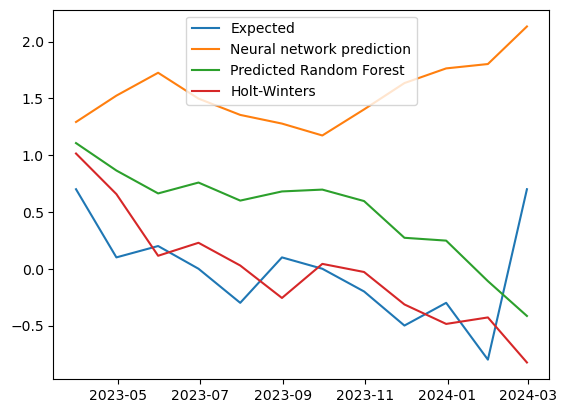

In [28]:
test.index = pd.to_datetime(test.index)
pred.index = pd.to_datetime(pred.index)
pyplot.plot(test.index,y, label='Expected')
pyplot.plot(test.index, z, label='Neural network prediction')
pyplot.plot(test.index,yhat, label='Predicted Random Forest')
pyplot.plot(pred.index, pred, label='Holt-Winters')
pyplot.legend(loc='best')
pyplot.show()